In [2]:
from notebooks_tools import *
from gbdt_tools import *
from xgboost import plot_importance
import operator
main_path = "/extra/Erez/uBoone/AnalysisTreesAna"

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [1]:
parameters['evnts_frac']

NameError: name 'parameters' is not defined

# Define parameters
set the GBDTs hyper-parameters

In [4]:
data_type_arr=['MC_BNB','openCOSMIC_MC'] 
nevents_train_arr=[300000,200000] 
parameters = dict({ 
        'evnts_frac':1,# events fraction to process
        'debug':2, # prints out information during the processes
        'scale_pos_weight':2., # Balancing of positive and negative weights.
        'objective':'multi:softprob', # Specify the learning task and the corresponding learning objective or a custom objective function to be used      
        #  in previous rounds was'objective':'binary:logistic'
        'eta':0.025, # Boosting learning rate        
        'eval_metric':'merror', # a custom evaluation metric      
        'silent':True, # Whether to print messages while running boosting
        'nthread':60, # Number of parallel threads used to run xgboost.     
        'min_child_weight':4, # Minimum sum of instance weight(hessian) needed in a child.        
        'max_depth':13,# Maximum tree depth for base learners
        'gamma':0.7, # Minimum loss reduction required to make a further partition on a leaf node of the tree.
        'colsample_bytree':0.5, # Subsample ratio of columns when constructing each tree
        'subsample':0.8, # Subsample ratio of the training instance       
        'num_class':5, #  If early stopping occurs...     
        'Ntrees':500,        
        'Nfolds':10,
        'num_round':200
#         'reg_alpha':1e-5 # L1 regularization term on weights
        })
# [http://xgboost.readthedocs.io/en/latest/python/python_api.html]
train_filename = []
for data_name,nevnts in zip(data_type_arr,nevents_train_arr):
    train_filename.append(TrainingSampleFileName( data_name , nevnts , main_path))    
    print_filename( train_filename[-1] , "input: traininig sample file" )

input: traininig sample file
/extra/Erez/uBoone/AnalysisTreesAna/TrainingSamples/trainsample_300000_tracks_MC_BNB.csv
input: traininig sample file
/extra/Erez/uBoone/AnalysisTreesAna/TrainingSamples/trainsample_200000_tracks_openCOSMIC_MC.csv


# comments:
katherine gives in parameter_opt:
eta=0.05
max_depth=9
gamma=0
colsample_bytree=0.8


# Load the data
from the training files

In [5]:
data,label,weight = boost_multiscore.load_data( bnb_mc_filename=train_filename[0] , 
                                               corsika_mc_filename=train_filename[1] ,   
                                               debug=parameters['debug'] ,
                                               feature_names=feature_names ,
                                               tracks_frac=parameters['evnts_frac'] )

took only a fraction of 1 of tracks from MC-BNB and CORSIKA samples:
140370 protons, 30221 pions, 61410 muons, 55994 em
200000 cosmic tracks


# cross-validation step
from the training files

In [ ]:
do_cross_validation = yesno('cross validate?')
if do_cross_validation:
    test_error,test_falsepos,test_falseneg,scores = boost_multiscore.run_cv( data , label , weight , parameters , Nskf=100)

cross validate? [Y/n] yes
enumerate(skf): <enumerate object at 0x7f8cec1404b0>
plst: [('eval_metric', 'merror'), ('scale_pos_weight', 2.0), ('debug', 2), ('num_round', 200), ('num_class', 5), ('evnts_frac', 1), ('Ntrees', 500), ('colsample_bytree', 0.5), ('silent', True), ('nthread', 60), ('min_child_weight', 4), ('subsample', 0.8), ('eta', 0.025), ('objective', 'multi:softprob'), ('Nfolds', 10), ('max_depth', 13), ('gamma', 0.7), ('eval_metric', 'mlogloss')]
On fold 0


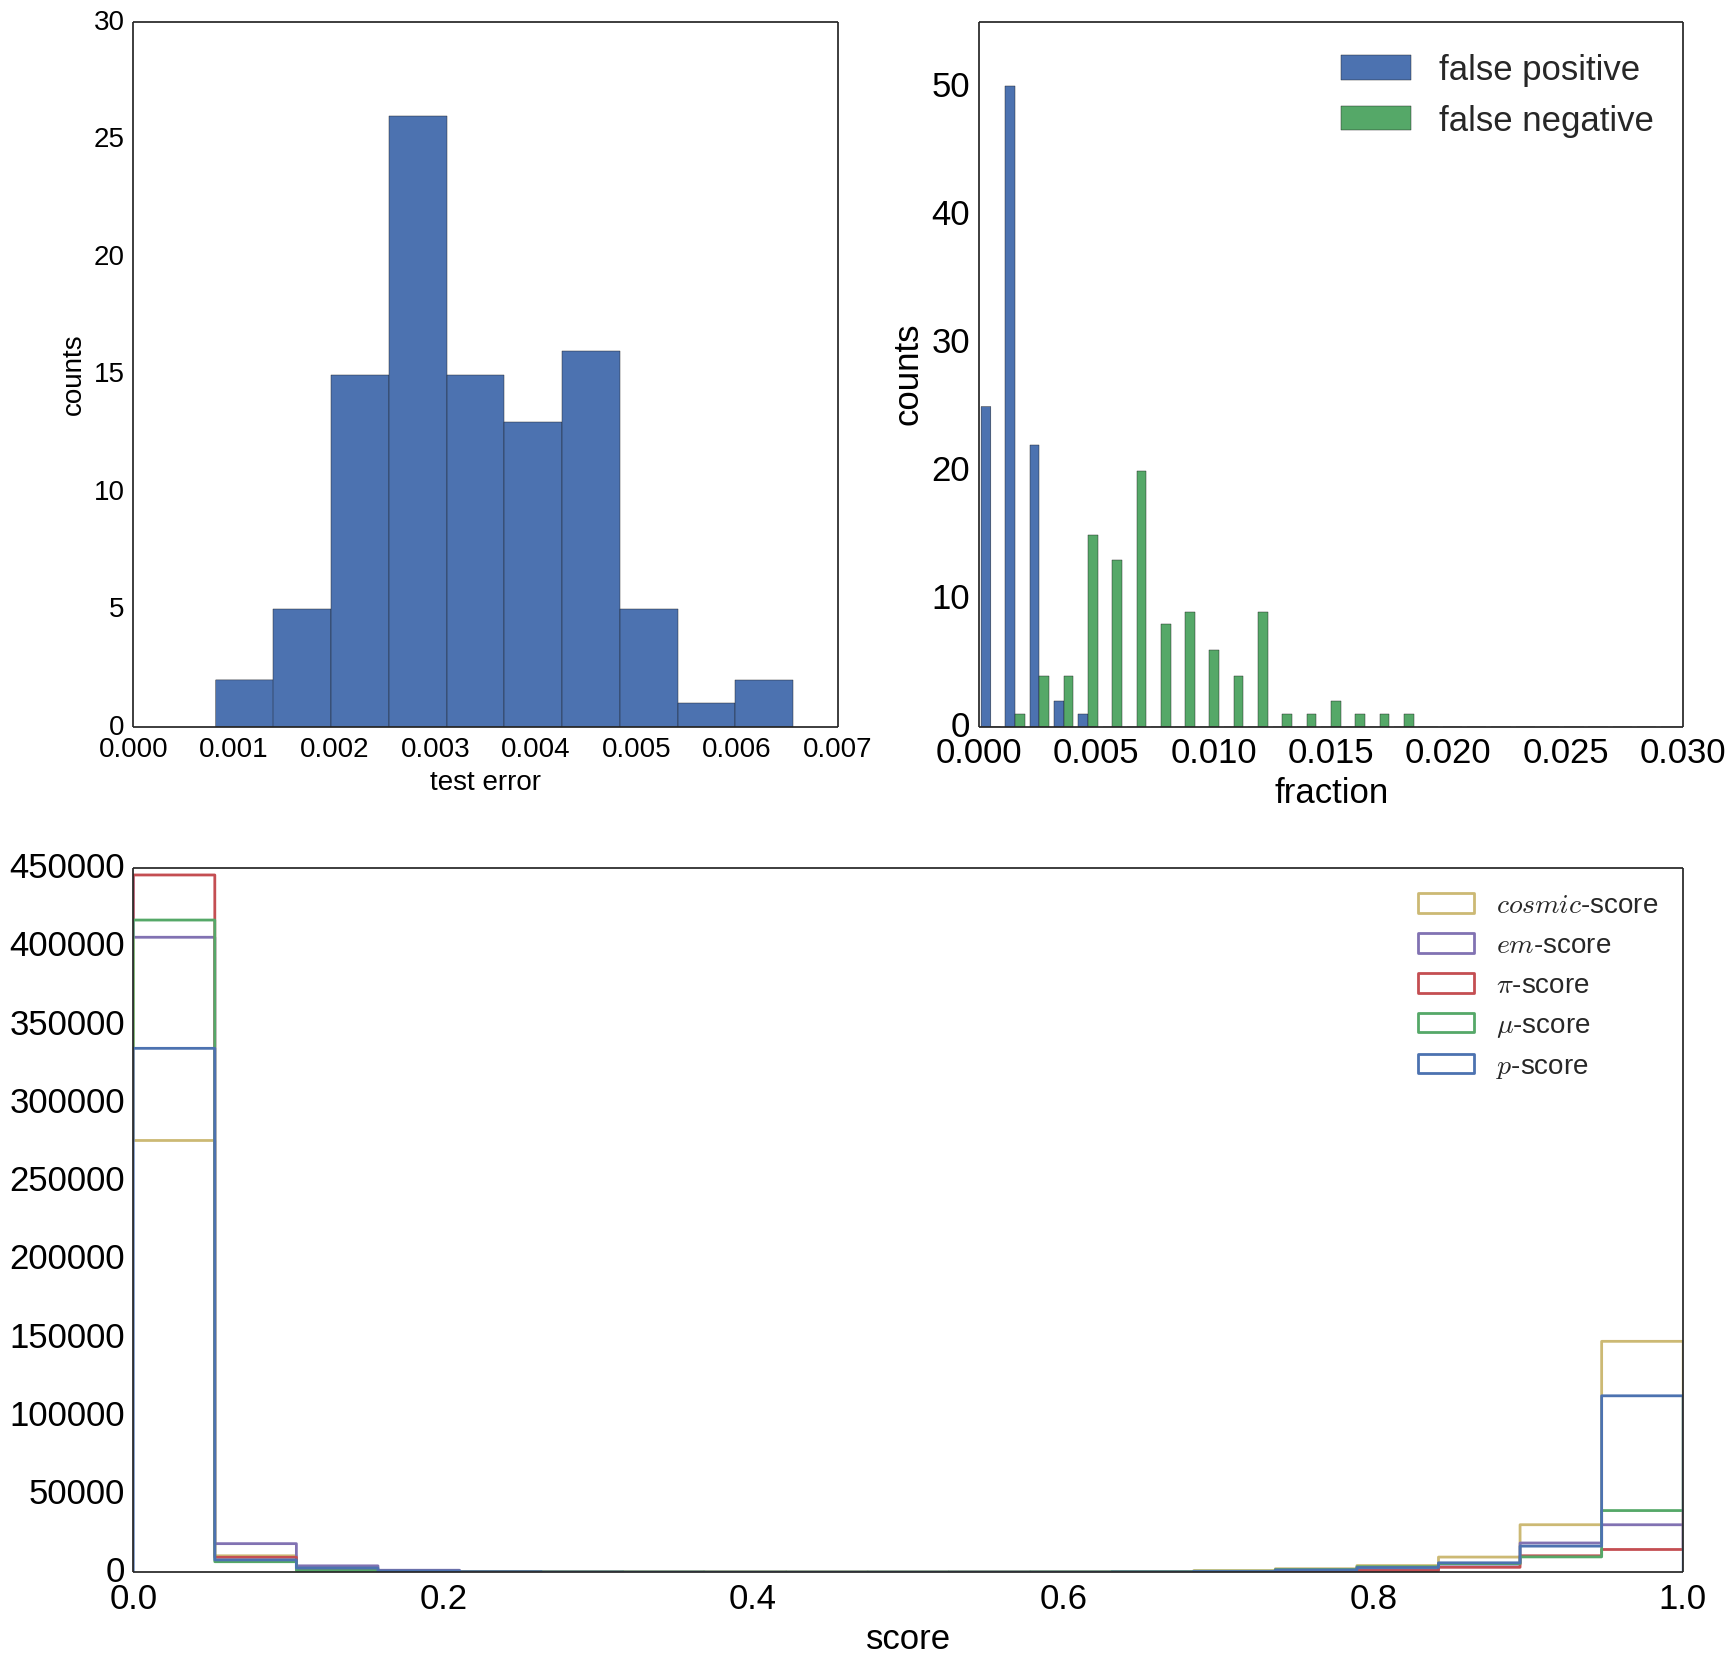

In [20]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(2,2,1)
plt.hist(test_error);
set_axes(ax,x_label='test error',y_label='counts',fontsize=20)

ax = fig.add_subplot(2,2,2)
h,bins,_=plt.hist([test_falsepos,test_falseneg],bins=np.linspace(0,0.03,30),label=['false positive','false negative']);
set_axes(ax,x_label='fraction',y_label='counts',fontsize=25)
ax.set_xlim(0,0.03)
ax.set_ylim(0,1.1*np.max(h))
plt.legend(fontsize=25,loc='best')

ax = fig.add_subplot(2,1,2)
plt.hist([scores[0],scores[1],scores[2],scores[3],scores[4]],
         label=['$p$-score','$\\mu$-score','$\\pi$-score','$em$-score','$cosmic$-score'],
         histtype='step',linewidth=2,bins=np.linspace(0,1,20));
set_axes(ax,x_label='score',fontsize=25)
plt.legend(fontsize=20,loc='best')
plt.savefig('/home/erez/uBoone/GBDTs/models/plots/cv_test_errors_scores_%s_%s.pdf'%(data_type_arr[0],data_type_arr[1]))

# optimization of the hyper-parameters

In [ ]:
do_optimize_paramters = yesno('optimize parameters?')
if do_optimize_paramters:
    results_optimize = test_error,test_falsepos,test_falseneg,scores = boost_multiscore.parameter_opt( data , label , weight , parameters )

optimize parameters? [Y/n] yes


In [26]:
results_optimize.to_csv('/home/erez/uBoone/GBDTs/models/plots/results_optimize_%s_%s.csv'%(data_type_arr[0],data_type_arr[1]))

# build the tree

In [24]:
do_make_bdt = yesno('make bdt?')
if do_make_bdt:
    bdt = boost_multiscore.make_bdt( data , label , weight , parameters)

make bdt? [Y/n] yes


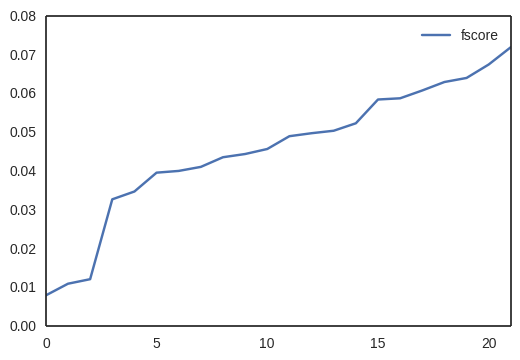

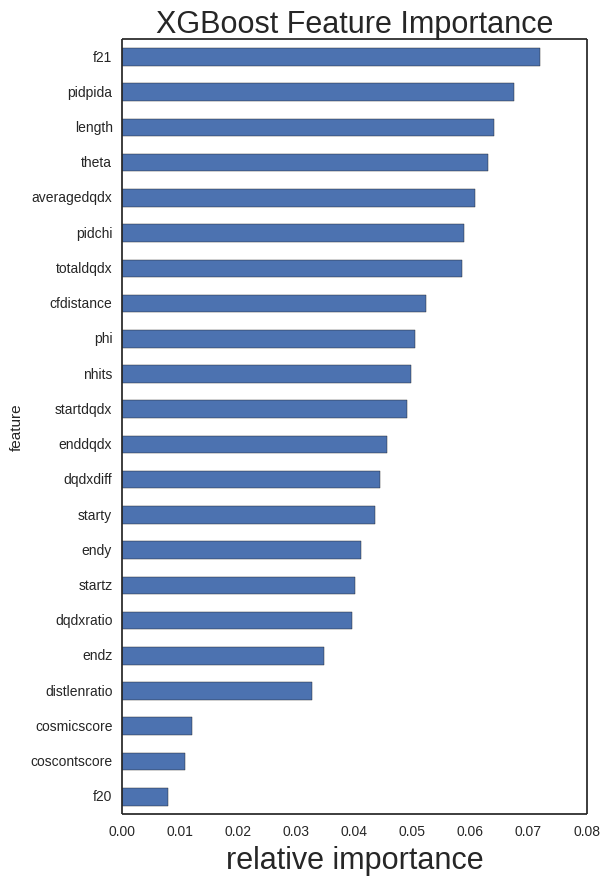

In [33]:
# plot importances with features names...
outfile = open('xgb.fmap', 'w')
i = 0
for feat in feature_names:
    if feat is not 'truth_KE' and feat is not 'MCpdgCode':
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
outfile.close()


importance = bdt.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance',fontsize=22)
plt.xlabel('relative importance',fontsize=22)
plt.show()
plt.gcf().savefig( '/home/erez/uBoone/GBDTs/models/plots/importances_model_%s_%s_Feb2017.pdf'%(data_type_arr[0],data_type_arr[1]))

In [28]:
# bdt.save_model('/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/GBDTmodels/model_2017Jan28.bst')
bdt.save_model('/home/erez/uBoone/GBDTs/models/bst_model_%s_%s_Feb2017.bst'%(data_type_arr[0],data_type_arr[1]))

# model 2 - no phi, no theta
set the GBDTs hyper-parameters

In [6]:
model_no_angles_name='MC_BNB_openCOSMIC_MC_NoTheta_NoPhi'
feature_names_no_angles = [ # geometry
                 'nhits','length','starty','startz','endy','endz','distlenratio'
                 # calorimetry
                 ,'startdqdx','enddqdx','dqdxdiff','dqdxratio','totaldqdx','averagedqdx'
                 # uboonecode tagging and PID
                 ,'cosmicscore','coscontscore','pidpida','pidchi'
                 # optical information - unused for open cosmic MC
                 ,'cfdistance'
                 ,'MCpdgCode' , 'truth_KE' #  necessary for training..
                ]

In [7]:
data_no_angles,label_no_angles,weight_no_angles = boost_multiscore.load_data( bnb_mc_filename=train_filename[0] , 
                                               corsika_mc_filename=train_filename[1] ,   
                                               debug=parameters['debug'] ,
                                               feature_names=feature_names_no_angles ,
                                               tracks_frac=parameters['evnts_frac'] )

took only a fraction of 1 of tracks from MC-BNB and CORSIKA samples:
140370 protons, 30221 pions, 61410 muons, 55994 em
200000 cosmic tracks


# cross-validation for model 2 (no theta, no phi)

In [ ]:
do_cross_validation = yesno('cross validate?')
if do_cross_validation:
    test_error_no_angles,test_falsepos_no_angles,test_falseneg_no_angles,scores_no_angles = boost_multiscore.run_cv( data_no_angles,label_no_angles,weight_no_angles , parameters , Nskf=100)

cross validate? [Y/n] yes
enumerate(skf): <enumerate object at 0x7f125ceee640>
plst: [('eval_metric', 'merror'), ('scale_pos_weight', 2.0), ('debug', 2), ('num_round', 200), ('num_class', 5), ('evnts_frac', 1), ('Ntrees', 500), ('colsample_bytree', 0.5), ('silent', True), ('nthread', 60), ('min_child_weight', 4), ('subsample', 0.8), ('eta', 0.025), ('objective', 'multi:softprob'), ('Nfolds', 10), ('max_depth', 13), ('gamma', 0.7), ('eval_metric', 'mlogloss')]
On fold 0


In [ ]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(2,2,1)
plt.hist(test_error);
set_axes(ax,x_label='test error',y_label='counts',fontsize=20)

ax = fig.add_subplot(2,2,2)
h,bins,_=plt.hist([test_falsepos_no_angles,test_falseneg_no_angles],bins=np.linspace(0,0.03,30),label=['false positive','false negative']);
set_axes(ax,x_label='fraction',y_label='counts',fontsize=25)
ax.set_xlim(0,0.03)
ax.set_ylim(0,1.1*np.max(h))
plt.legend(fontsize=25,loc='best')

ax = fig.add_subplot(2,1,2)
plt.hist([scores[0],scores[1],scores[2],scores[3],scores[4]],
         label=['$p$-score','$\\mu$-score','$\\pi$-score','$em$-score','$cosmic$-score'],
         histtype='step',linewidth=2,bins=np.linspace(0,1,20));
set_axes(ax,x_label='score',fontsize=25)
plt.legend(fontsize=20,loc='best')
plt.savefig('/home/erez/uBoone/GBDTs/models/plots/cv_test_errors_scores_%s_%s_%s.pdf'%(model_no_angles_name,data_type_arr[0],data_type_arr[1]))